In [ ]:
pip install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.1 MB/s eta 0:00:00


In [ ]:
import nltk
import warnings
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, RNN
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,Nadam
from collections import defaultdict,Counter
from wordcloud import WordCloud, STOPWORDS
from tensorflow.keras.models import Model
import matplotlib.patches as mpl_patches
import nltk.translate.bleu_score as bleu
from textstat import flesch_reading_ease
from nltk.tokenize import word_tokenize
import matplotlib.lines as mlines
from nltk.corpus import stopwords
warnings.filterwarnings("ignore")
from tabulate import tabulate
from textblob import TextBlob
from datetime import datetime
from nltk.util import ngrams
import matplotlib.cm as cm
import missingno as msno
import scipy.stats as st
import matplotlib as mpl
from tqdm import tqdm
import pandas as pd
import numpy as np
import zipfile
import random
import pickle
import shutil
tqdm.pandas()
import spacy
import pytz
import re
import os
import io

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def convert_m2_to_data_frame(m2_file_path, id=0):
    m2 = open(m2_file_path).read().strip().split("\n\n")
    skip = {"noop", "UNK", "Um"}
    correct_sentences_array = []
    incorrect_sentences_array = []

    for sentences in tqdm(m2):
        sentences = sentences.split("\n")
        incorrect_sentences = sentences[0].split()[1:] # Ignore "S "
        incorrect_sentences_array.append(str(' '.join(incorrect_sentences)))
        correct_sentences = incorrect_sentences.copy()

        edits = sentences[1:]
        offset = 0
        for edit in edits:
            edit = edit.split("|||")
            if edit[1] in skip: continue
            coder = int(edit[-1])
            if coder != id: continue
            span = edit[0].split()[1:]
            start = int(span[0])
            end = int(span[1])
            corrected = edit[2].split()
            correct_sentences[start+offset:end+offset] = corrected
            offset = offset-(end-start)+len(corrected)
        correct_sentences_array.append(str(' '.join(correct_sentences)))

    data_frame = pd.DataFrame()
    data_frame["correct"] = correct_sentences_array
    data_frame["incorrect"] = incorrect_sentences_array
    return data_frame

In [ ]:
gec_dataset = convert_m2_to_data_frame(r"lang8.train.auto.bea19.m2")

100%|██████████| 1037561/1037561 [00:08<00:00, 124842.15it/s]


In [ ]:
gec_dataset.sample(7)

,correct,incorrect
695433,Sand volleyball,Sand volleyball
5142,We do n't see when Coluche is in the plane for...,We do n't see when Coluche is in the plane for...
696188,"In Africa , we believe that we can tell whethe...","In Africa , we believe that we can tell whethe..."
600046,"I had an English conversation class at night ,...","I had an English conversation class at night ,..."
204251,Work would mostly involve maintenance of the h...,What we expect you to work here mainly would b...
51421,So a person who is good at everyting has to do...,So a pesron who is good at everyting has to do...
765556,"Some of them are really kind , and the rest ma...","Some of them arereally kind , and the rest may..."


In [ ]:
gec_dataset.to_csv(r'gec_dataset.csv', index=False)

In [ ]:
gec_dataset = pd.read_csv(r'gec_dataset.csv')

In [ ]:
gec_dataset['correct_char_count'] = gec_dataset['correct'].astype('str').apply(lambda x:len(x))
gec_dataset['incorrect_char_count'] = gec_dataset['incorrect'].astype('str').apply(lambda x:len(x))

In [ ]:
gec_dataset['correct_word_count'] = gec_dataset['correct'].astype('str').apply(lambda x:len(x.split()))
gec_dataset['incorrect_word_count'] = gec_dataset['incorrect'].astype('str').apply(lambda x:len(x.split()))

In [ ]:
pd.DataFrame(gec_dataset.isna().sum(), columns=['missing_count'])

,missing_count
correct,1
incorrect,1
correct_char_count,0
incorrect_char_count,0
correct_word_count,0
incorrect_word_count,0


In [ ]:
gec_dataset = gec_dataset.dropna().reset_index(drop=True)

In [ ]:
print(f"Total duplicate pairs: {len(gec_dataset[gec_dataset['correct'] == gec_dataset['incorrect']])}")

Total duplicate pairs: 539201


In [ ]:
gec_dataset = gec_dataset[gec_dataset['correct'] != gec_dataset['incorrect']]

In [ ]:
print(f'Total number of duplicates: {gec_dataset.duplicated().sum()}')

Total number of duplicates: 0


In [ ]:
gec_dataset = gec_dataset.drop_duplicates().reset_index(drop=True)

In [ ]:
contractions_dictionary = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not",
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have","n\'t":" not","\'re":" are","\'s": " is","\'d":" would",
                     "\'ll": " will","\'t":" not","\'ve": " have","\'m":" am"}

contractions_regular_expression = re.compile('(%s)' % '|'.join(contractions_dictionary.keys()))

def expand_contractions(text,contractions_dict=contractions_dictionary):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_regular_expression.sub(replace, text)

In [ ]:
def clean(text):
    text = re.sub('\s*\<.*?\>\s', '', text)
    text = re.sub('\s*\(.*?\)\s', '', text)
    text = re.sub('\s*\[.*?\]\s', '', text)
    text = re.sub('\s*\{.*?\}\s', '', text)
    text = re.sub("[-+@#^/|*(){}$~<>=_%:;]", "", text)
    text = text.replace("\\", "")
    text = re.sub("\[", "", text)
    text = re.sub("\]", "",text)
    text = re.sub("\<", "", text)
    text = re.sub("\>", "", text)
    text = re.sub("\(", "", text)
    text = re.sub("\)", "", text)
    text = re.sub("[0-9]", "", text)
    text = ' '.join(text.split())
    return text

In [ ]:
gec_dataset['correct'] = gec_dataset['correct'].progress_apply(clean)
gec_dataset['correct'] = gec_dataset['correct'].progress_apply(expand_contractions)
gec_dataset['incorrect'] = gec_dataset['incorrect'].progress_apply(clean)
gec_dataset['incorrect'] = gec_dataset['incorrect'].progress_apply(expand_contractions)

100%|██████████| 496338/496338 [00:09<00:00, 51633.74it/s]


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
def plot_univariate(gec_dataset, feature_name):
    random_color = (random.random(), random.random(), random.random())
    gec_dataset.plot(kind='kde', y=feature_name, figsize=(25,5), grid=True, color=random_color)
    plt.title(f'KDE-{feature_name.replace("_"," ")}')
    plt.show()

In [ ]:
def show_percentiles(gec_dataset, feature_name, quantile_range, quantile_incr):
    quantiles = np.arange(quantile_range[0], quantile_range[1], quantile_incr)
    quantiles_array = [np.percentile(gec_dataset[feature_name], i) for i in quantiles]
    return pd.DataFrame(quantiles_array, columns=[feature_name]).set_index(quantiles).transpose()

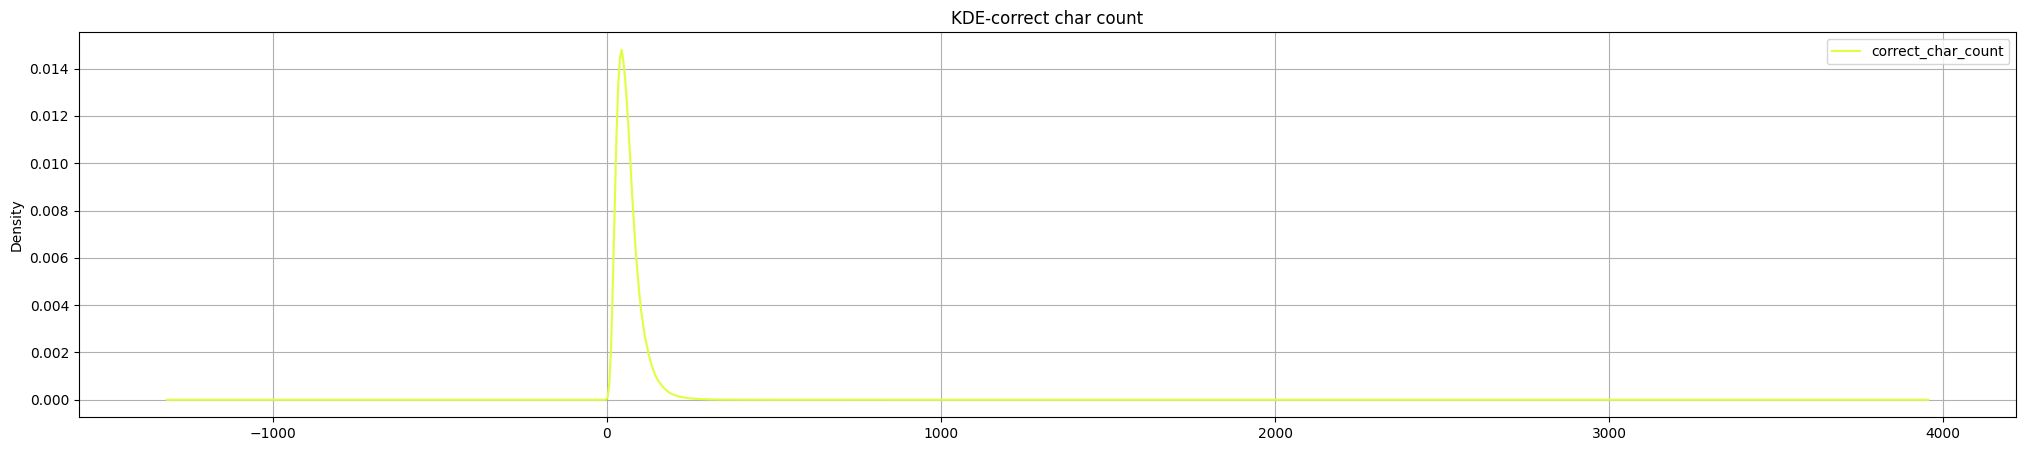

In [ ]:
plot_univariate(gec_dataset, 'correct_char_count')

In [ ]:
show_percentiles(gec_dataset, 'correct_char_count', (0, 101), 10)

,0,10,20,30,40,50,60,70,80,90,100
correct_char_count,1.0,28.0,36.0,43.0,49.0,57.0,65.0,74.0,88.0,111.0,2637.0


In [ ]:
show_percentiles(gec_dataset, 'correct_char_count', (90, 101), 2)

,90,92,94,96,98,100
correct_char_count,111.0,119.0,128.0,142.0,168.0,2637.0


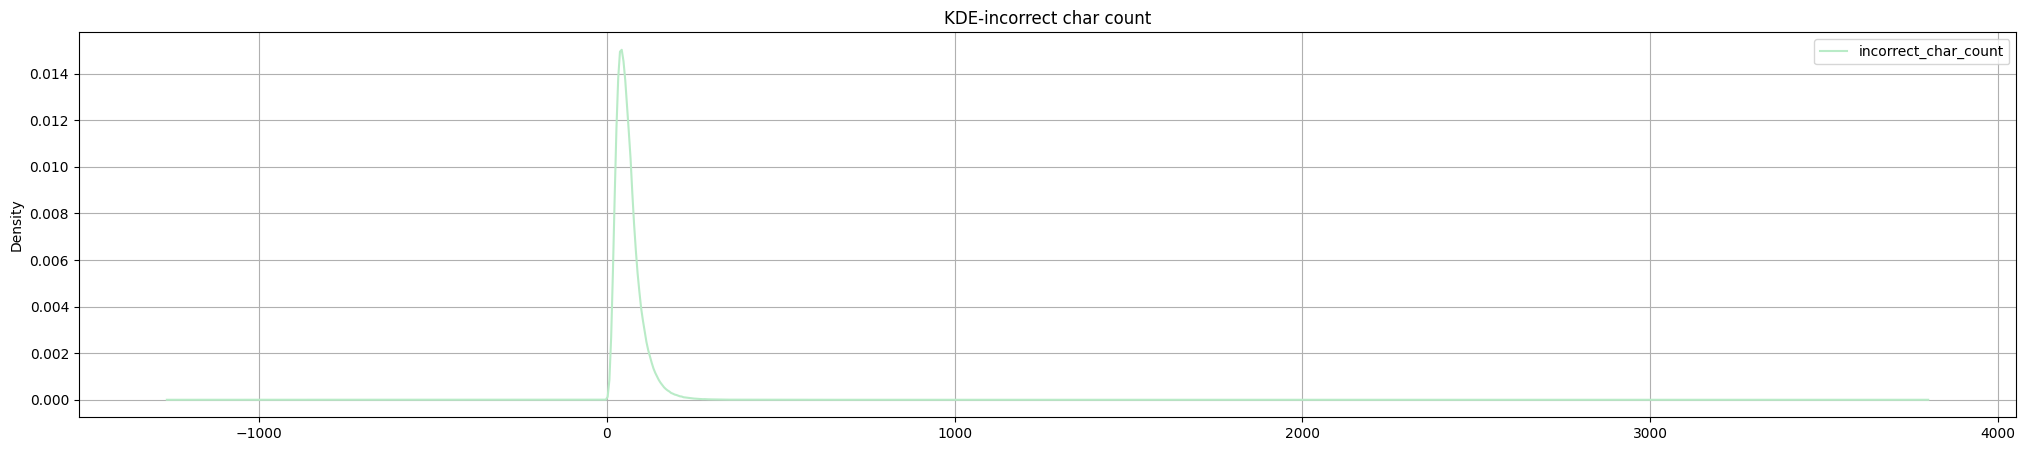

In [ ]:
plot_univariate(gec_dataset, 'incorrect_char_count')

In [ ]:
show_percentiles(gec_dataset, 'incorrect_char_count', (0, 101), 10)

,0,10,20,30,40,50,60,70,80,90,100
incorrect_char_count,1.0,26.0,34.0,41.0,47.0,54.0,62.0,72.0,85.0,108.0,2533.0


In [ ]:
show_percentiles(gec_dataset, 'incorrect_char_count', (90, 101), 2)

,90,92,94,96,98,100
incorrect_char_count,108.0,116.0,125.0,140.0,164.0,2533.0


In [ ]:
def plot_scatter(gec_dataset, feat_1, feat_2, title):
    fig,axs = plt.subplots(figsize=(10,10))
    x = sorted(list(gec_dataset[feat_1]))
    y = sorted(list(gec_dataset[feat_2]))
    random_color = (random.random(), random.random(), random.random())
    axs.scatter(x, y, marker=".", label=feat_1, color=random_color)
    line = mlines.Line2D([0, 1], [0, 1], color='black', linestyle=':', label='Normal Line')
    transform = axs.transAxes
    line.set_transform(transform)
    axs.add_line(line)
    axs.set_ylabel(feat_2)
    axs.grid()
    axs.set_xlabel(feat_1)
    axs.annotate(f"Correlation Score:{round((np.corrcoef(x, y)[0][1]), 4)}", xy=(0.7, 0.5), xycoords='axes fraction',
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(10, -40), textcoords='offset points', ha='center', fontsize=16)
    if title:
        plt.title(title)
    plt.show()

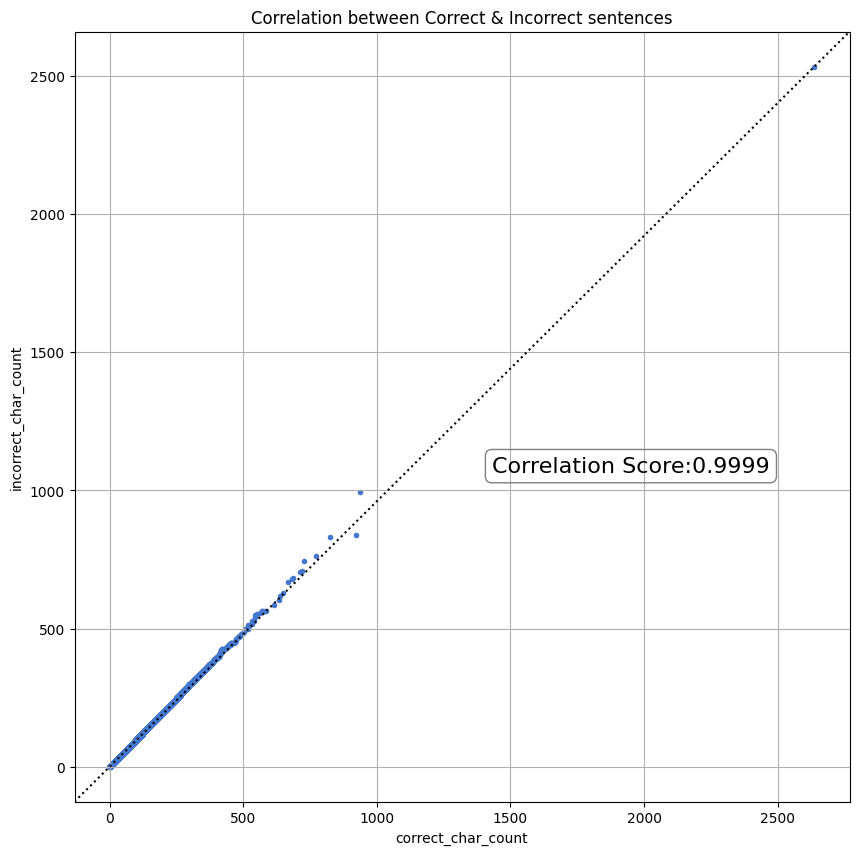

In [ ]:
plot_scatter(gec_dataset, 'correct_char_count', 'incorrect_char_count', title='Correlation between Correct & Incorrect sentences')

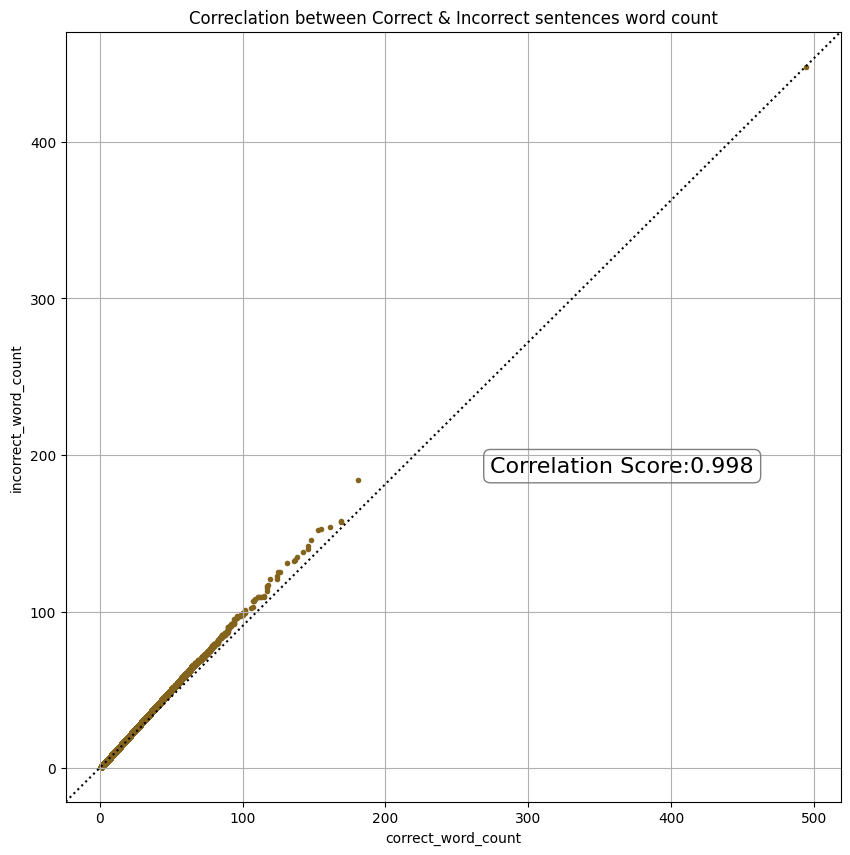

In [ ]:
plot_scatter(gec_dataset, 'correct_word_count', 'incorrect_word_count', 'Correclation between Correct & Incorrect sentences word count')

In [ ]:
def get_ngram_frequency(rows_text, n=2):
    new = rows_text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    vectorize = CountVectorizer(ngram_range=(n, n)).fit(rows_text)
    bag_of_words = vectorize.transform(rows_text)
    sum_words = bag_of_words.sum(axis=0)
    words_frequency = [(word, sum_words[0, idx]) for word, idx in vectorize.vocabulary_.items()]
    return words_frequency

def plot_top_ngrams(words_frequency, n_top=5, title=None):
    data_frame = pd.DataFrame()
    data_frame['gram'] = [i[0] for i in words_frequency]
    data_frame['frequency'] = [i[1] for i in words_frequency]
    data_frame['percentage'] = data_frame['frequency']*100/data_frame['frequency'].sum()
    data_frame = data_frame.sort_values('frequency', ascending=False)
    data_frame = data_frame.iloc[:n_top]
    figure, axis = plt.subplots(figsize=(20, n_top/2))
    axis = sns.barplot(x = "frequency", y = "gram", data=data_frame, palette="nipy_spectral_r", orient='h')
    for i, p in enumerate(axis.patches):
        width = p.get_width()
        axis.text(width + 1,
                p.get_y() + p.get_height() / 2,
                ' {:1.0f}'.format(width)+' ('+str(round(data_frame['percentage'].iloc[i],2))+'%)',
                ha = 'left',
                va = 'center')
    axis.set_xlim(xmin=0.0, xmax=round(max(data_frame['frequency']), -4)*1.1)
    if title:
        plt.title(title)
    plt.show()

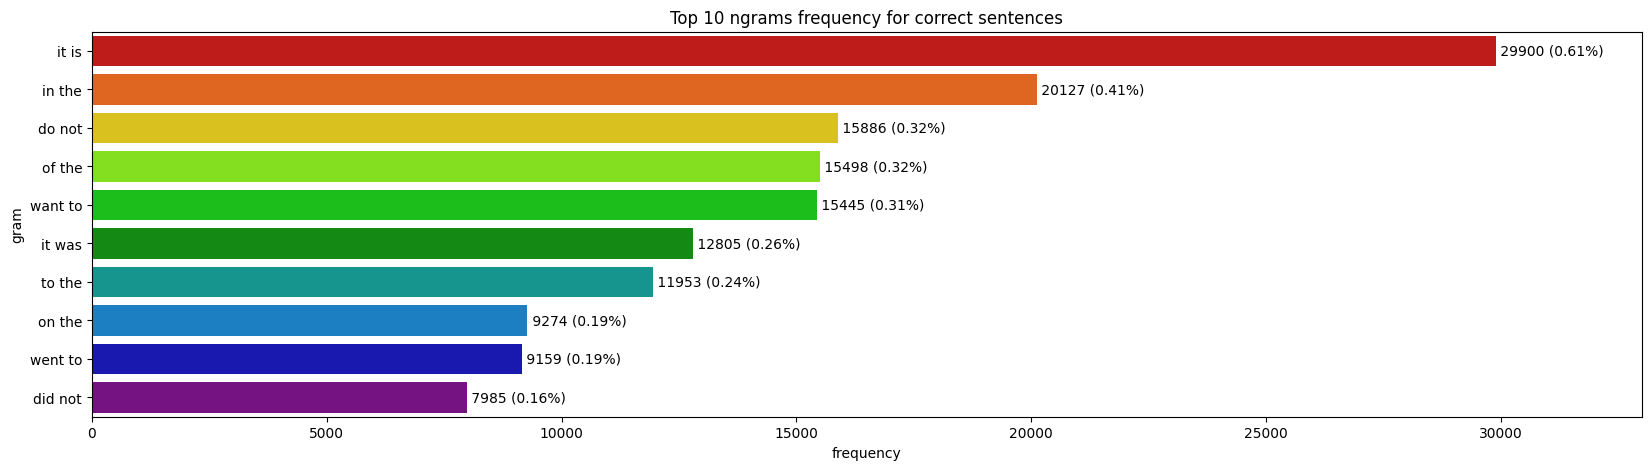

In [ ]:
plot_top_ngrams(get_ngram_frequency(gec_dataset['correct']), 10, title='Top 10 ngrams frequency for correct sentences')

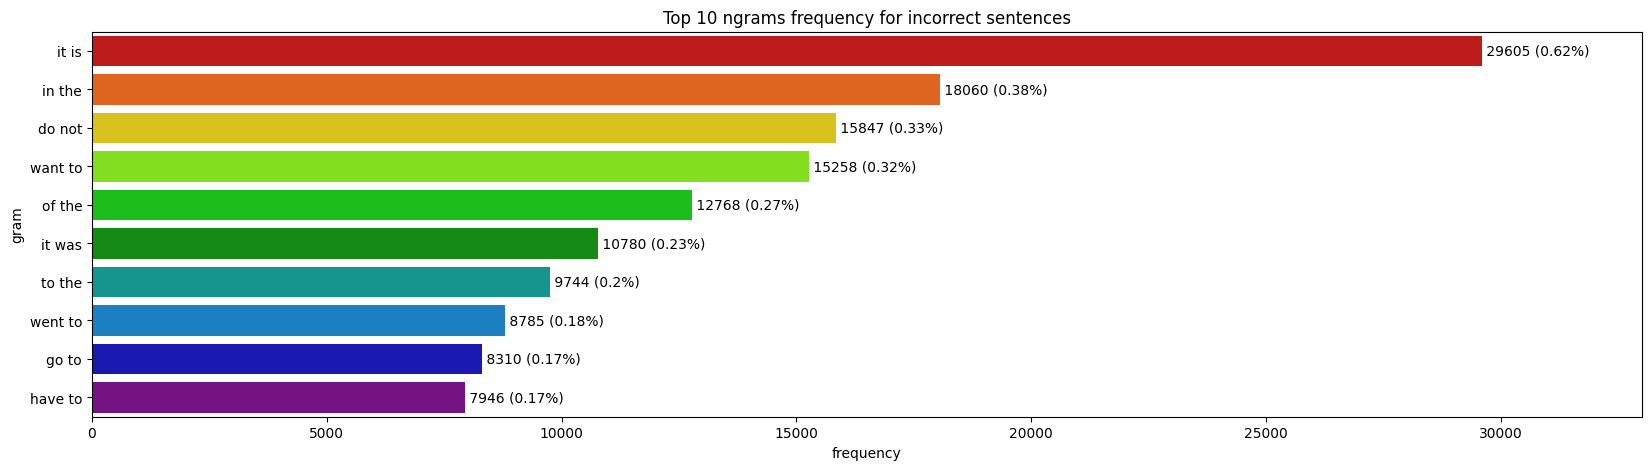

In [ ]:
plot_top_ngrams(get_ngram_frequency(gec_dataset['incorrect']), 10, title='Top 10 ngrams frequency for incorrect sentences')

In [ ]:
stop = set(stopwords.words('english'))

In [ ]:
def generate_wordcloud(text):
    corpus = []
    stemming_words = PorterStemmer()
    lemmatizing_words = WordNetLemmatizer()
    for news in tqdm(text):
        words = [w for w in word_tokenize(news) if (w not in stop)]
        words = [lemmatizing_words.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus

def plot_wordcloud(corpus, title=None):
    wordcloud = WordCloud(background_color='black', stopwords=set(STOPWORDS),
                          max_words=100, max_font_size=30, scale=3, random_state=1)
    wordcloud = wordcloud.generate(str(corpus))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    if title:
        plt.title(title)
    plt.show()

100%|██████████| 496338/496338 [01:37<00:00, 5091.27it/s]


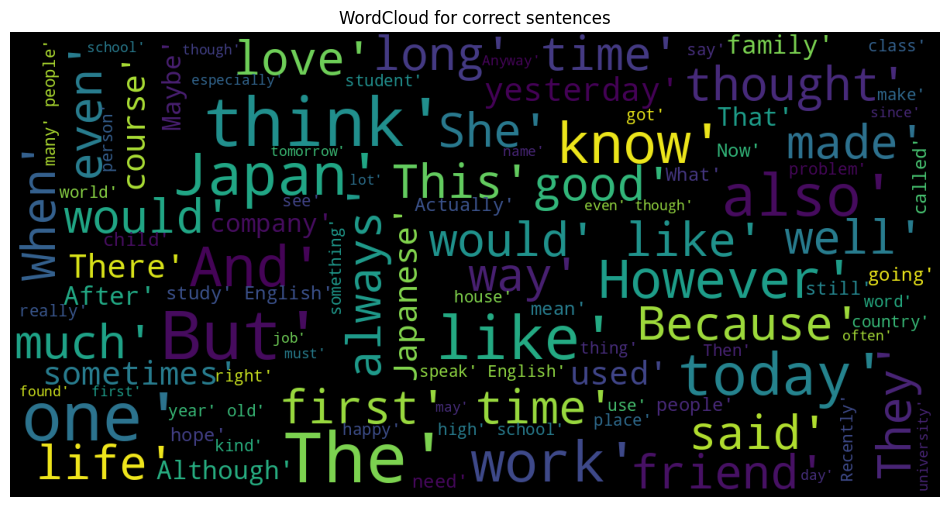

In [ ]:
plot_wordcloud(generate_wordcloud(gec_dataset['correct']), 'WordCloud for correct sentences')

100%|██████████| 496338/496338 [01:32<00:00, 5364.83it/s]


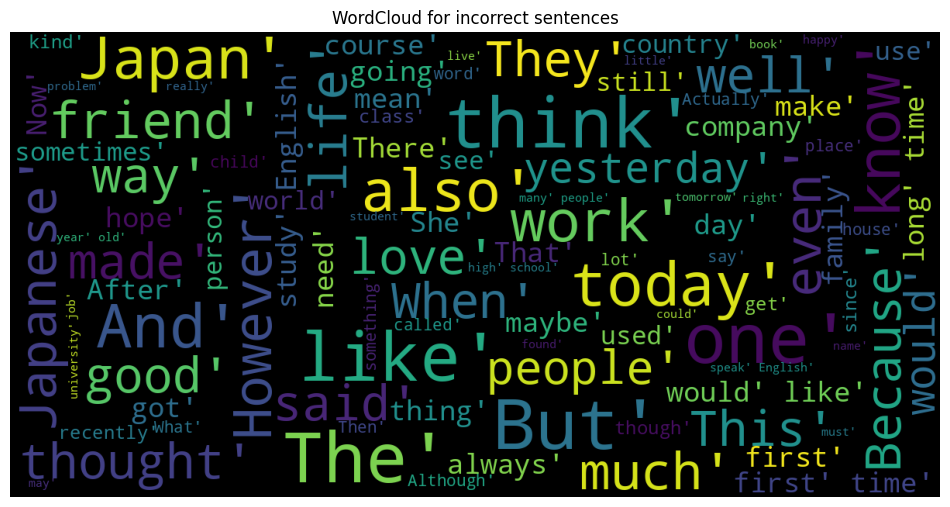

In [ ]:
plot_wordcloud(generate_wordcloud(gec_dataset['incorrect']), 'WordCloud for incorrect sentences')

In [ ]:
train, test = train_test_split(gec_dataset, test_size=0.1)
train, validation = train_test_split(train, test_size=0.1)

In [ ]:
train['dec_correct_inp'] = '<start> ' + train['correct'].astype(str)
train['dec_correct_out'] = train['correct'].astype(str) + ' <end>'

validation['dec_correct_inp'] = '<start> ' + validation['correct'].astype(str)
validation['dec_correct_out'] = validation['correct'].astype(str) + ' <end>'

test['dec_correct_inp'] = '<start> ' + test['correct'].astype(str)
test['dec_correct_out'] = test['correct'].astype(str) + ' <end>'

In [ ]:
train.to_csv(r'gec_train.csv')
validation.to_csv(r'gec_validation.csv')
test.to_csv(r'gec_test.csv')

In [ ]:
tokenizer_encoder = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n', lower=False)
tokenizer_encoder.fit_on_texts(train['incorrect'].astype(str).values)

In [ ]:
vocabulary_size_encoder = len(tokenizer_encoder.word_index.keys())
print('Encoder words vocab size:', vocabulary_size_encoder)

Encoder words vocab size: 92084


In [ ]:
tokenizer_decoder = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n', lower=False)
tokenizer_decoder.fit_on_texts(train['dec_correct_inp'].astype(str).values)

In [ ]:
vocabulary_size_decoder = len(tokenizer_decoder.word_index.keys())
print('Decoder words vocababulary size:', vocabulary_size_decoder)

Decoder words vocababulary size: 77978


In [ ]:
tokenizer_decoder.word_index['<start>'], tokenizer_decoder.word_index.get('<end>', None)

(1, None)

In [ ]:
tokenizer_decoder.word_index['<end>'] = max(tokenizer_decoder.word_index.values()) + 1

In [ ]:
with open(r'tokenizer_encoder.pkl', 'wb') as f:
  pickle.dump(tokenizer_encoder, f)

with open(r'tokenizer_decoder.pkl', 'wb') as f:
  pickle.dump(tokenizer_decoder, f)

In [ ]:
tokenizer_encoder = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n', lower=False)
tokenizer_encoder.fit_on_texts(train['incorrect'].astype(str).values)
tokenizer_decoder = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n', lower=False)
tokenizer_decoder.fit_on_texts(train['dec_correct_inp'].astype(str).values)

vocabulary_size_encoder = len(tokenizer_encoder.word_index.keys())
print('Encoder vocabulary size:', vocabulary_size_enc)
vocabulary_size_decoder = len(tokenizer_decoder.word_index.keys())
print('Decoder vocabulary size::', vocabulary_size_decoder)

tokenizer_decoder.word_index['<start>'], tokenizer_decoder.word_index.get('<end>', None)
tokenizer_decoder.word_index['<end>'] = max(tokenizer_decoder.word_index.values()) + 1

#text2seq
train_encoder_input = tokenizer_encoder.texts_to_sequences(train['incorrect'].astype(str).values)
validation_encoder_input = tokenizer_encoder.texts_to_sequences(validation['incorrect'].astype(str).values)
test_encoder_input = tokenizer_encoder.texts_to_sequences(test['incorrect'].astype(str).values)

#padding
max_seq_len = 12
train_encoder_input = pad_sequences(train_encoder_input, maxlen=max_seq_len, padding='post', truncating='post')
validation_encoder_input = pad_sequences(validation_encoder_input, maxlen=max_seq_len, padding='post', truncating='post')
test_encoder_input = pad_sequences(test_encoder_input, maxlen=max_seq_len, padding='post', truncating='post')

#text2seq
train_decoder_input = tokenizer_decoder.texts_to_sequences(train['dec_correct_inp'].astype(str).values)
validation_decoder_input = tokenizer_decoder.texts_to_sequences(validation['dec_correct_inp'].astype(str).values)
test_decoder_input = tokenizer_decoder.texts_to_sequences(test['dec_correct_inp'].astype(str).values)

#padding
train_decoder_input = pad_sequences(train_decoder_input, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_decoder_input = pad_sequences(validation_decoder_input, maxlen=max_seq_len+1, padding='post', truncating='post')
test_decoder_input = pad_sequences(test_decoder_input, maxlen=max_seq_len+1, padding='post', truncating='post')

#text2seq
train_decoder_output = tokenizer_decoder.texts_to_sequences(train['dec_correct_out'].astype(str).values)
validation_decoder_output = tokenizer_decoder.texts_to_sequences(validation['dec_correct_out'].astype(str).values)
test_decoder_output = tokenizer_decoder.texts_to_sequences(test['dec_correct_out'].astype(str).values)

#padding
train_decoder_output = pad_sequences(train_decoder_output, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_decoder_output = pad_sequences(validation_decoder_output, maxlen=max_seq_len+1, padding='post', truncating='post')
test_decoder_output = pad_sequences(test_decoder_output, maxlen=max_seq_len+1, padding='post', truncating='post')

Encoder vocabulary size: 92084
Decoder vocabulary size:: 77978


In [ ]:
with open(r'train_encoder_input.pkl', 'wb') as f:
  pickle.dump(train_encoder_input, f)

with open(r'validation_encoder_input.pkl', 'wb') as f:
  pickle.dump(validation_encoder_input, f)

with open(r'test_encoder_input.pkl', 'wb') as f:
  pickle.dump(test_encoder_input, f)

with open(r'train_decoder_input.pkl', 'wb') as f:
  pickle.dump(train_decoder_input, f)

with open(r'validation_decoder_input.pkl', 'wb') as f:
  pickle.dump(validation_decoder_input, f)

with open(r'test_decoder_input.pkl', 'wb') as f:
  pickle.dump(test_decoder_input, f)

with open(r'train_decoder_output.pkl', 'wb') as f:
  pickle.dump(train_decoder_output, f)

with open(r'validation_decoder_output.pkl', 'wb') as f:
  pickle.dump(validation_decoder_output, f)

with open(r'test_decoder_output.pkl', 'wb') as f:
  pickle.dump(test_decoder_output, f)